In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import json
import requests
import re
import os
from datetime import datetime as dt
from pandas.io.json import json_normalize
import shapefile
from sklearn import preprocessing
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.decomposition import PCA

df_main_categ = pd.read_csv('df_main_categ.csv')

mms = MinMaxScaler()
selected_cols = ['price_sqm', 'floor_area_sqm','year','distance_to_nearest_mrt','distance_to_downtown','storey_avg','toilet_number',
       'room_number']

selected_cols_without_year = ['price_sqm', 'floor_area_sqm','distance_to_nearest_mrt','distance_to_downtown','storey_avg','toilet_number',
       'room_number']

df_by_year = df_main_categ[selected_cols].groupby('year').mean()
df_by_year[selected_cols_without_year] = mms.fit_transform(df_by_year[selected_cols_without_year])
df_by_year = df_by_year.reset_index()
df_by_year.columns


Index(['year', 'price_sqm', 'floor_area_sqm', 'distance_to_nearest_mrt',
       'distance_to_downtown', 'storey_avg', 'toilet_number', 'room_number'],
      dtype='object')

In [50]:
df_non_hot_categ = pd.read_csv('df_non_hot.csv')
df_non_hot_categ = df_non_hot_categ[['year',
       'floor_area_sqm', 'resale_price', 
       'remaining_lease', 
       'price_sqm', 'distance_to_downtown',
       'distance_to_nearest_mrt', 'toilet_number', 'room_number', 'Bus',
       'Entertainment', 'Food', 'School', 'Shop']]
df_non_hot_categ = df_non_hot_categ.fillna(0)
df_non_hot_categ = mms.fit_transform(df_non_hot_categ).astype('float64')
df_non_hot_categ

array([[0.87096774, 0.05734767, 0.1811652 , ..., 0.15714286, 0.        ,
        0.18181818],
       [0.87096774, 0.13978495, 0.19553073, ..., 0.1       , 0.        ,
        0.        ],
       [0.87096774, 0.13978495, 0.20510774, ..., 0.04285714, 0.        ,
        0.04545455],
       ...,
       [0.29032258, 0.42293907, 0.37031125, ..., 0.04285714, 0.        ,
        0.        ],
       [0.29032258, 0.42293907, 0.3471668 , ..., 0.1       , 0.        ,
        0.09090909],
       [0.29032258, 0.41935484, 0.38228252, ..., 0.1       , 0.        ,
        0.09090909]])

In [43]:
pca = PCA(8)  # project from 14 to 8 dimensions
# np_non_hot_categ = df_non_hot_categ.to_numpy()
projected = pca.fit_transform(df_non_hot_categ)
print(df_non_hot_categ.shape)
print(projected.shape)

(839610, 14)
(839610, 8)


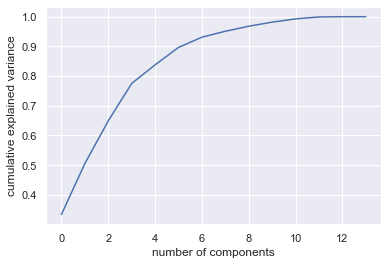

In [45]:
pca = PCA().fit(df_non_hot_categ)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# var0_#### rank the variance of the variablefilter = VarianceThreshold(threshold=0.0)
# var0_filter.fit(df_final, y= df_final['price_sqm'])

# pd.DataFrame(df_final.columns[var0_filter.get_support()==False])
df_non_hot_categ = pd.read_csv('df_non_hot.csv')
df_non_hot_categ['storey_range_adj']=df_non_hot_categ['storey_range'].apply(lambda x: int(x[:2]))
df_non_hot_categ = df_non_hot_categ[['year',
       'floor_area_sqm', 'resale_price', 
       'remaining_lease', 'storey_range_adj',
       'price_sqm', 'distance_to_downtown',
       'distance_to_nearest_mrt', 'toilet_number', 'room_number', 'Bus',
       'Entertainment', 'Food', 'School', 'Shop']]
df_non_hot_categ = df_non_hot_categ.fillna(0)

var5_filter = VarianceThreshold(threshold=0)
var5_filter.fit(df_non_hot_categ, y= df_non_hot_categ['price_sqm'])

pd.DataFrame(df_non_hot_categ.columns[var5_filter.get_support()])

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(f_classif, k = 10)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(df_non_hot_categ, df_non_hot_categ['price_sqm'])
names = df_non_hot_categ.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

In [90]:
feature_cols = ['floor_area_sqm', 
       'remaining_lease', 'storey_range_adj','distance_to_downtown',
       'distance_to_nearest_mrt', 'toilet_number', 'room_number', 'Bus',
       'Entertainment', 'Food', 'School', 'Shop']
# selector = SelectKBest(f_classif, k = 10)
# X_new = selector.fit_transform(df_non_hot_categ[feature_cols],df_non_hot_categ['price_sqm'])

# # Get back the kept features as a DataFrame with dropped columns as all 0s
# selected_features = pd.DataFrame(select_k_best_classifier.inverse_transform(X_new),
#                             index=df_non_hot_categ.index,
#                             columns= feature_cols)
# selected_columns = selected_features.columns[selected_features.var() !=0]

selector = SelectKBest(f_classif, k=7)
selector.fit(df_non_hot_categ[feature_cols], df_non_hot_categ['price_sqm'])
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = df_non_hot_categ[feature_cols].iloc[:,cols]


In [91]:
features_df_new

,floor_area_sqm,remaining_lease,storey_range_adj,toilet_number,room_number,Entertainment,Food
0,44.0,61,10,1,2,0.0,11.0
1,67.0,60,1,2,3,0.0,7.0
2,67.0,62,1,2,3,1.0,3.0
3,68.0,62,4,2,3,0.0,11.0
4,67.0,62,1,2,3,1.0,3.0
...,...,...,...,...,...,...,...
839605,142.0,69,10,2,3,1.0,9.0
839606,142.0,70,1,2,3,2.0,25.0
839607,146.0,70,7,2,3,1.0,3.0
839608,146.0,70,4,2,3,2.0,7.0
